In [8]:
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import nilearn
from nilearn import plotting
from nilearn import image
import matplotlib.pyplot as plt
import codecs
import copy
from numpy import ma
import matplotlib
from matplotlib import cbook
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

In [9]:
lcolor = '#268bd2'
gcolor = '#c11b17'
wcolor = '#859900'
ccolor ='#ffcc00'

In [10]:
# Loading information of the AAL atlas with with nilearn
out = nilearn.datasets.fetch_atlas_aal(version='SPM12', data_dir=None, url=None, resume=True, verbose=1)
indices = out['indices']
labels = out['labels']
AAL_region = dict(zip(labels, indices))

# Laading AAL atlas to manupulate it and build a new nifti image
AAL_img = nib.load("AAL.nii")
AAL_data =  AAL_img.get_data()
AAL_affine = AAL_img.affine

# dt = AAL_data.dtype
# dt.name
# AAL_data.shape

In [11]:
def smoother(data, fwhm=2):
  # First the compute the mean image, from the 4D series of image
  mean_func = image.mean_img(data)
  return  image.smooth_img(mean_func, fwhm)

def smooth_ploter(data):
  # First the compute the mean image, from the 4D series of image
  mean_func = image.mean_img(data)
  for smoothing in range(0, 25, 5):
      smoothed_img = image.smooth_img(mean_func, smoothing)
#       plotting.plot_epi(smoothed_img)
      plotting.plot_glass_brain(smoothed_img, 
                                colorbar=True, 
                                title="Smoothing %imm" % smoothing)

class MidPointNorm(Normalize):    
    def __init__(self, midpoint=0, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self,vmin, vmax, clip)
        self.midpoint = midpoint

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")       
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = ma.getmask(result)
                result = ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint            
            resdat[resdat>0] /= abs(vmax - midpoint)            
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = ma.array(resdat, mask=result.mask, copy=False)                

        if is_scalar:
            result = result[0]            
        return result

    def inverse(self, value):
        if not self.scaled():
            raise ValueError("Not invertible until scaled")
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if cbook.iterable(value):
            val = ma.asarray(value)
            val = 2 * (val-0.5)  
            val[val>0]  *= abs(vmax - midpoint)
            val[val<0] *= abs(vmin - midpoint)
            val += midpoint
            return val
        else:
            val = 2 * (val - 0.5)
            if val < 0: 
                return  val*abs(vmin-midpoint) + midpoint
            else:
                return  val*abs(vmax-midpoint) + midpoint

In [12]:
# load row data for regions

# def val_normalizer(d, target_min=0, target_max=1):
#   _min = min(d.values())
#   _max = max(d.values())
#   for k in d.keys():
#     d[k] = (d[k]-_min)/(_max - _min) * (target_max-target_min) + target_min
#   return d

def creat_fmri_data(row_data):
  my_region_val={}
  with codecs.open(row_data, "r", "utf-8") as reader:
    for line in reader:
      parts = line.strip().split(',')
      my_region_val[AAL_region[parts[0]]] = float(parts[1])
  my_data = copy.copy(AAL_data)
  my_data = my_data.astype(float)
  for key, val in my_region_val.items():
    reg_index = float (key)
    my_data[(my_data == reg_index)] = val

  for key in indices:
    if key not in my_region_val:
      key = int(key)
      my_data[(my_data == key)] = 0.0
  filename = row_data + '.nii'
  img = nib.Nifti1Image(my_data, AAL_affine)
  nib.save(img, filename)
  return img, my_data, min(my_region_val.values()), max(my_region_val.values())

In [13]:
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

c = mcolors.ColorConverter().to_rgb

In [16]:
# generating fake fMRI

lstm_img, lstm_data, lstm_min, lstm_max = creat_fmri_data('data/lstm_a_fmri_row.txt')
glove_img, glove_data, glove_min, glove_max = creat_fmri_data('data/glov_a_fmri_row.txt')
word_img, word_data, word_min, word_max = creat_fmri_data('data/word_a_fmri_row.txt')
charword_img, charword_data, charword_min, charword_max = creat_fmri_data('data/charword_a_fmri_row.txt')

#Comparing the means of the 2 resting state datasetsa
diff_lg_img = image.math_img("img1 - img2",
                            img1=lstm_img,
                            img2=glove_img)

diff_lw_img = image.math_img("img1 - img2",
                            img1=lstm_img,
                            img2=word_img)

diff_lc_img = image.math_img("img1 - img2",
                            img1=lstm_img,
                            img2=charword_img)


diff_gw_img = image.math_img("img1 - img2",
                            img1=glove_img,
                            img2=word_img)

diff_gc_img = image.math_img("img1 - img2",
                            img1=glove_img,
                            img2=charword_img)

diff_wc_img = image.math_img("img1 - img2",
                            img1=word_img,
                            img2=charword_img)


lstm_img = smoother(lstm_img)
glove_img = smoother(glove_img)
word_img = smoother(word_img)
charword_img = smoother(charword_img)
diff_lg_img = smoother(diff_lg_img)
diff_lw_img = smoother(diff_lw_img)
diff_lc_img =smoother(diff_lc_img)
diff_gw_img = smoother(diff_gw_img)
diff_gc_img = smoother(diff_gc_img)
diff_wc_img = smoother(diff_wc_img)


lstm_mid = (lstm_min + lstm_max) /2
glove_mid = (glove_min + glove_max) /2
word_mid = (word_min + word_max) /2
charword_mid = (charword_min + charword_max) /2
 
norm_l = MidPointNorm(midpoint=lstm_mid)
norm_g = MidPointNorm(midpoint=glove_mid)
norm_w = MidPointNorm(midpoint=word_mid)
norm_c = MidPointNorm(midpoint=charword_mid)

print("lstm_min: " + str(lstm_min))
print("glove_min: " + str(glove_min))
print("word_min: " + str(word_min))
print("charword_min: " + str(charword_min))
print("====================================")
print("lstm_mid: " + str(lstm_mid))
print("glove_mid: " + str(glove_mid))
print("word_mid: " + str(word_mid))
print("charword_mid: " + str(charword_mid))
print("====================================")
print("lstm_max: " + str(lstm_max))
print("glove_max: " + str(glove_max))
print("word_max: " + str(word_max))
print("charword_max: " + str(charword_max))


lstm_min: 0.345791
glove_min: 0.471944
word_min: 0.476554
charword_min: 0.473814
lstm_mid: 0.542632
glove_mid: 0.5205124999999999
word_mid: 0.515886
charword_mid: 0.5148185
lstm_max: 0.739473
glove_max: 0.569081
word_max: 0.555218
charword_max: 0.555823


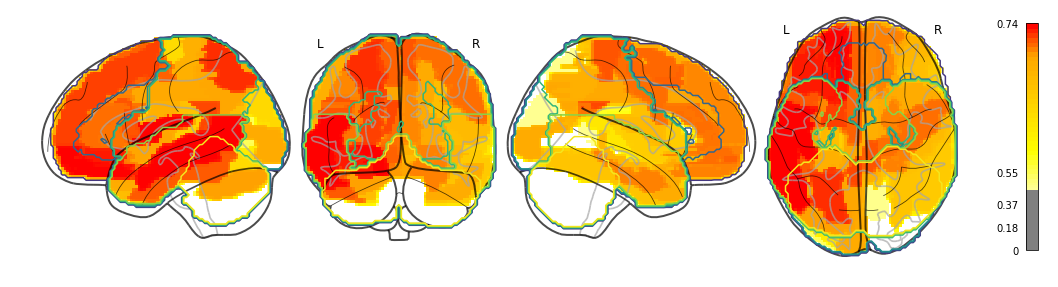

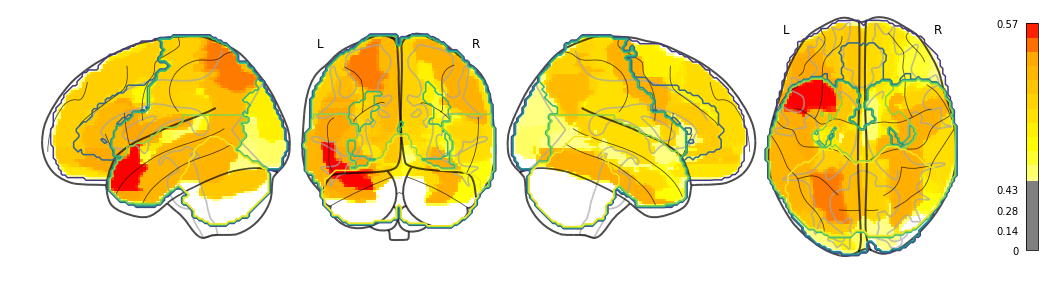

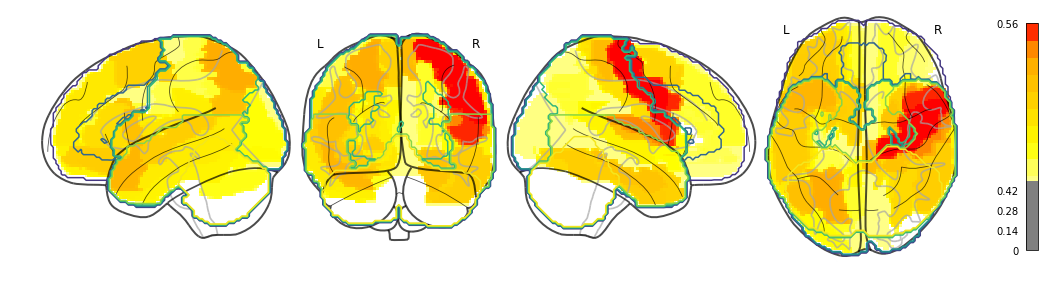

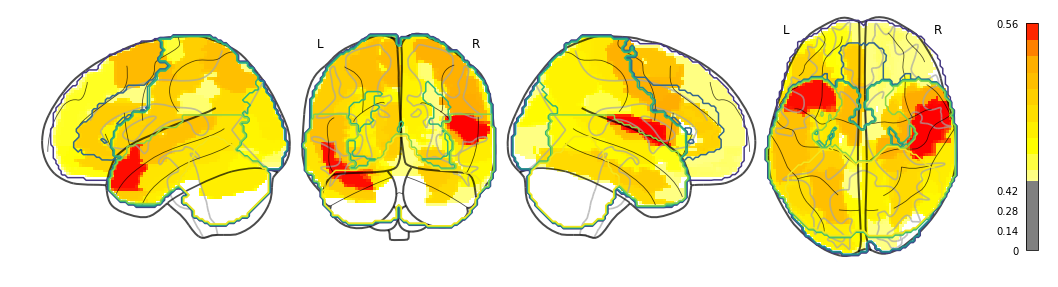

In [17]:
norm = MidPointNorm(midpoint=0.55)
# norm_l = norm_g = norm_w = norm_c = norm
vmax = 0.74
# lstm_max = glove_max = word_max = charword_max = vmax
cmap = make_colormap([c('white'), 0.4 , c('white'), c('yellow'), 0.6,  c('yellow'), c('orange'), 0.9, c('orange') , c('red')])

fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_glass_brain(lstm_img, 
                                  threshold=0.5,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = lstm_max,
                                    norm = norm_l,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('LSTM-HD', y=1.2)
fig.savefig('plot/lstm_brain.png', bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_glass_brain(glove_img, 
                                  threshold=0.5,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = glove_max,
                                    norm = norm_g,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('GloVe', y=1.2)
fig.savefig('plot/glove_brain.png', bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_glass_brain(word_img, 
                                  threshold=0.5,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = word_max,
                                    norm = norm_w,
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('OutWord-Emb', y=1.2)
fig.savefig('plot/word_brain.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_glass_brain(charword_img, 
                                  threshold=0.5,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = charword_max,
                                    norm = norm_c,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('CharWord-Emb', y=1.2)
fig.savefig('plot/charword_brain.png', bbox_inches='tight', dpi=300)


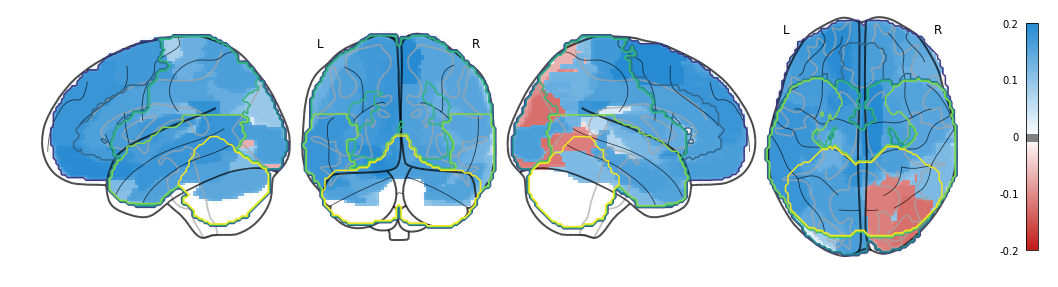

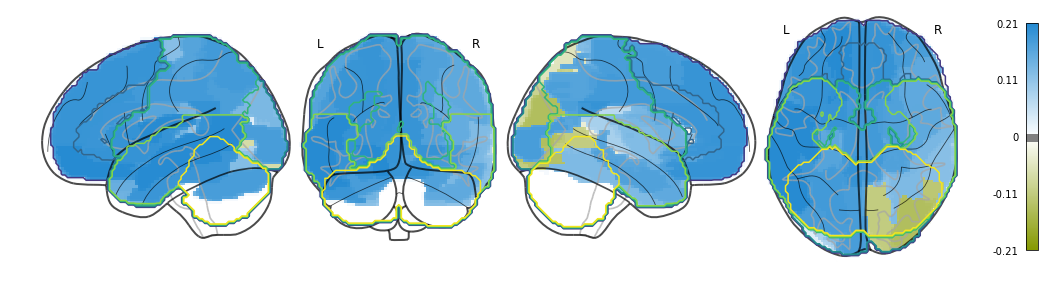

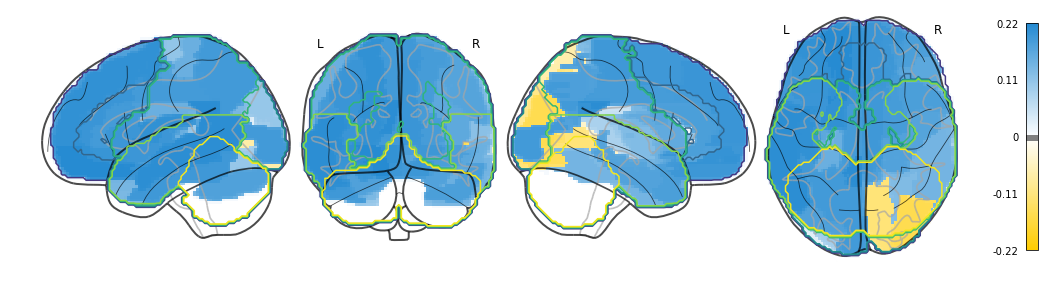

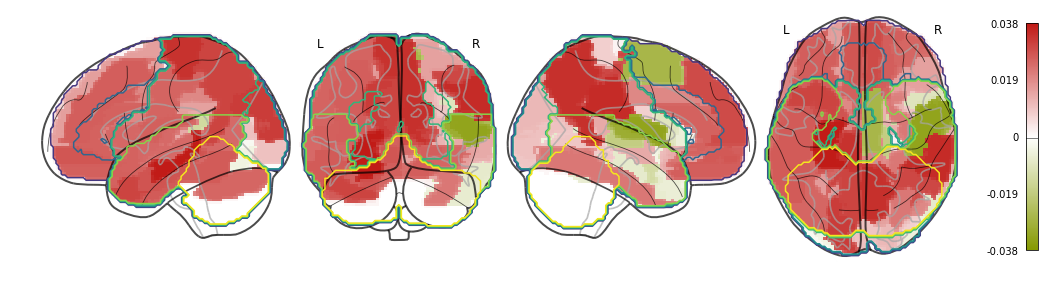

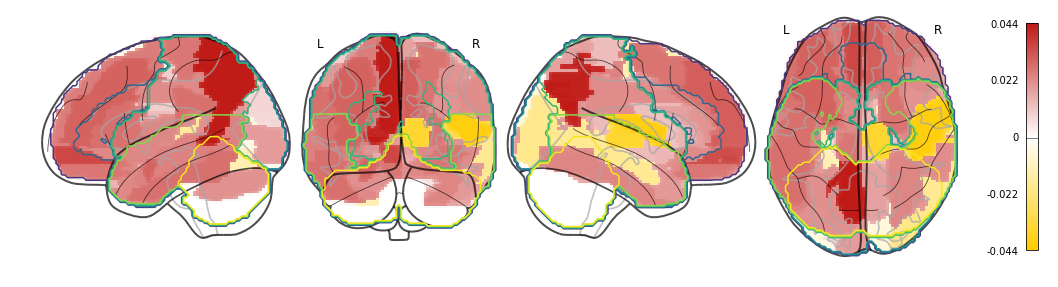

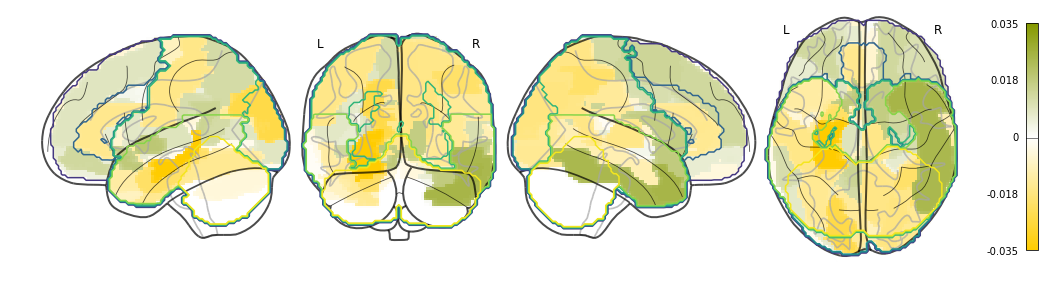

In [18]:
cmap = 'PiYG'
fig = plt.figure(figsize=(14, 3.5))
display = plotting.plot_glass_brain(diff_lg_img, 
        #                           threshold=0.05,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = make_colormap([c(gcolor), c('white'), 0.5, c('white'), c(lcolor)]),
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
                    ) 
# display.title('LSTM_HD - GloVe', y=1.2)
fig.savefig('plot/diff_lg_brain.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5))
display = plotting.plot_glass_brain(diff_lw_img, 
        #                           threshold=0.05,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = make_colormap([c(wcolor), c('white'), 0.5, c('white'), c(lcolor)]),
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
                    ) 
fig.savefig('plot/diff_lw_brain.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5))
display = plotting.plot_glass_brain(diff_lc_img, 
        #                           threshold=0.05,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = make_colormap([c(ccolor), c('white'), 0.5, c('white'), c(lcolor)]),
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
                    ) 
fig.savefig('plot/diff_lc_brain.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5))
display = plotting.plot_glass_brain(diff_gw_img, 
        #                           threshold=0.05,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = make_colormap([c(wcolor),c('white'), 0.5, c('white'), c(gcolor)]),
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
                    ) 
fig.savefig('plot/diff_gw_brain.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5))
display = plotting.plot_glass_brain(diff_gc_img, 
        #                           threshold=0.05,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = make_colormap([c(ccolor), c('white'), 0.5, c('white') , c(gcolor)]),
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
                    ) 
fig.savefig('plot/diff_gc_brain.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5))
display = plotting.plot_glass_brain(diff_wc_img, 
        #                           threshold=0.05,
                                  colorbar=True, 
                                  plot_abs=False,
                                  display_mode='lyrz',
                                    cmap = make_colormap([c(ccolor), c('white'), 0.5, c('white') , c(wcolor)]),
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
                    ) 
fig.savefig('plot/diff_wc_brain.png', bbox_inches='tight', dpi=300)

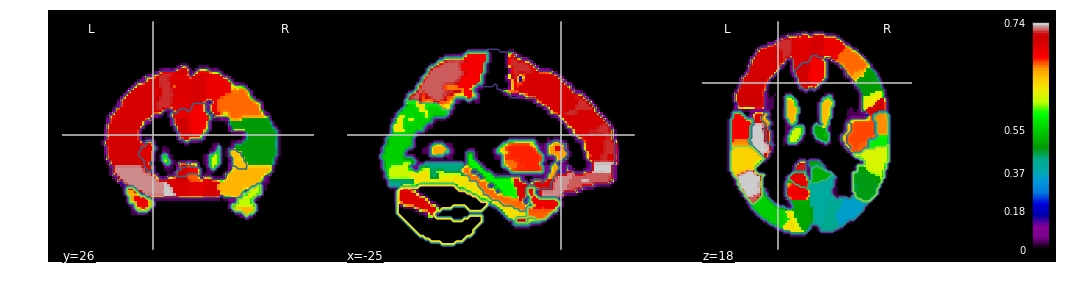

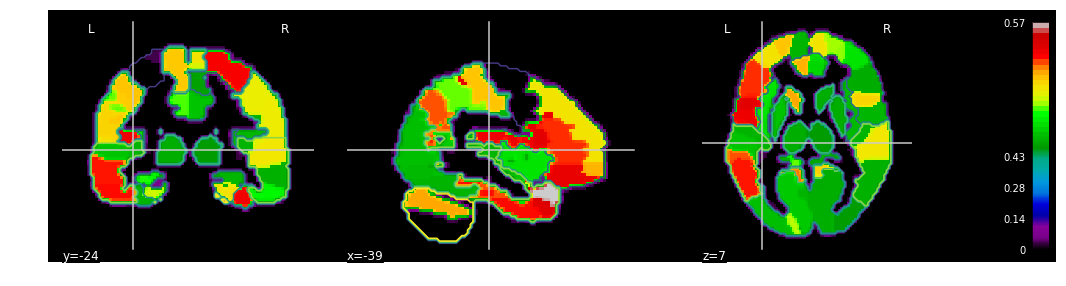

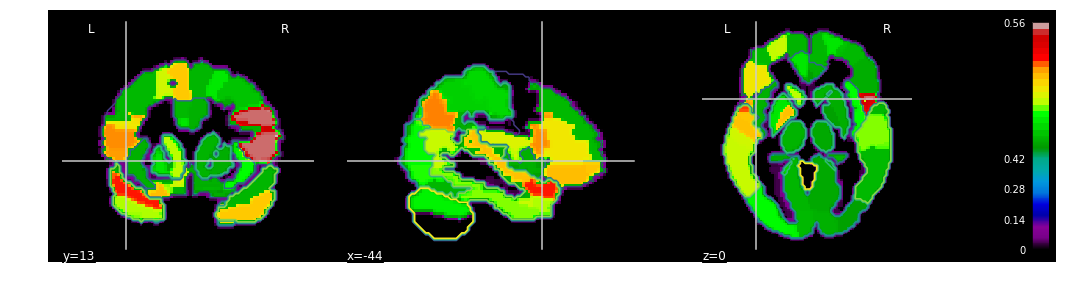

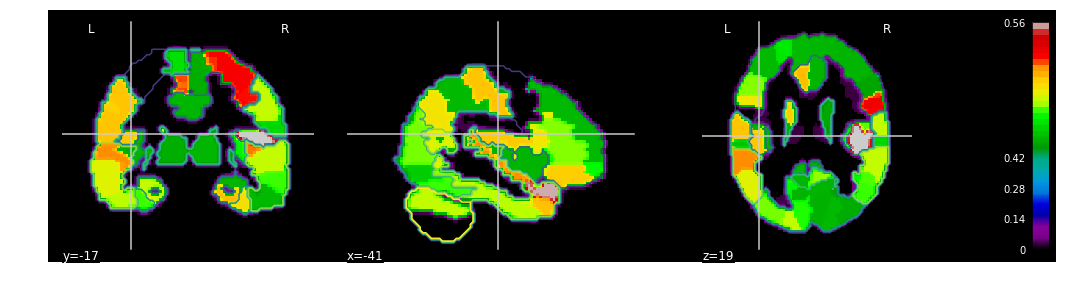

In [19]:
norm = MidPointNorm(midpoint=0.5)
# norm_l = norm_g = norm_w = norm_c = norm
vmax = 0.74
# lstm_max = glove_max = word_max = charword_max
cmap = 'hot'

fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_epi(lstm_img, 
#                                   threshold=0.5,
                                  colorbar=True, 
#                                     cmap = cmap,
                                    vmax = lstm_max,
                                    norm = norm_l,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('LSTM-HD', y=1.2)
fig.savefig('plot/lstm_brain_epi.png', bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_epi(glove_img, 
#                                   threshold=0.5,
                                  colorbar=True, 
#                                     cmap = cmap,
                                    vmax = glove_max,
                                    norm = norm_g,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('GloVe', y=1.2)
fig.savefig('plot/glove_brain_epi.png', bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_epi(word_img, 
#                                   threshold=0.5,
                                  colorbar=True, 
#                                     cmap = cmap,
                                    vmax = word_max,
                                    norm = norm_w,
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('OutWord-Emb', y=1.2)
fig.savefig('plot/word_brain_epi.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_epi(charword_img, 
#                                   threshold=0.5,
                                  colorbar=True, 
#                                     cmap = cmap,
                                    vmax = charword_max,
                                    norm = norm_c,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('CharWord-Emb', y=1.2)
fig.savefig('plot/charword_brain_epi.png', bbox_inches='tight', dpi=300)


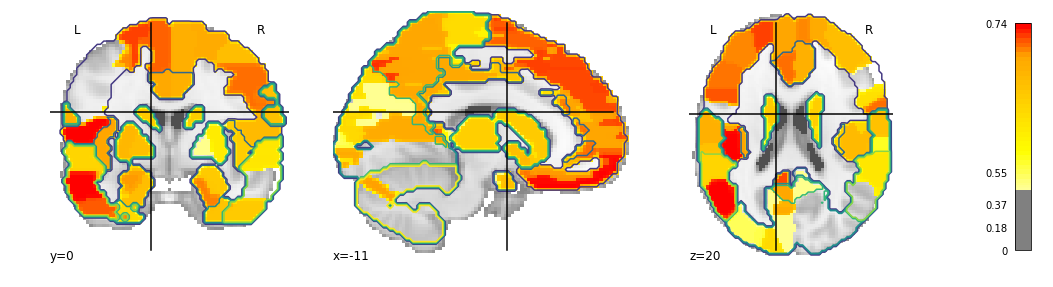

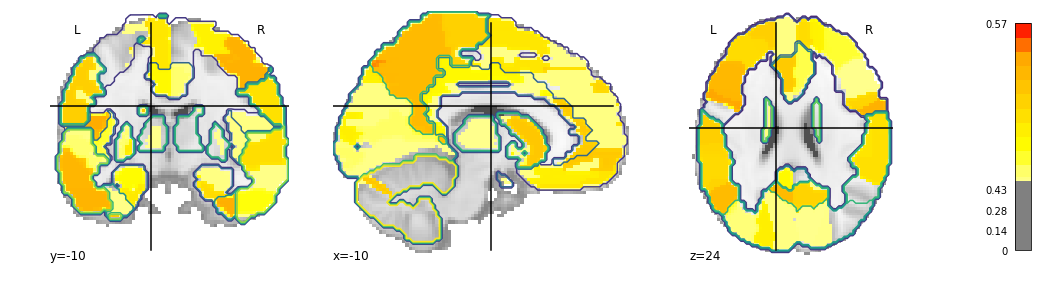

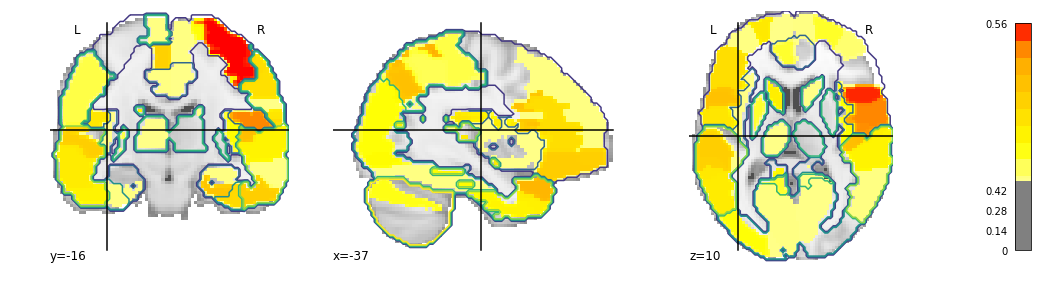

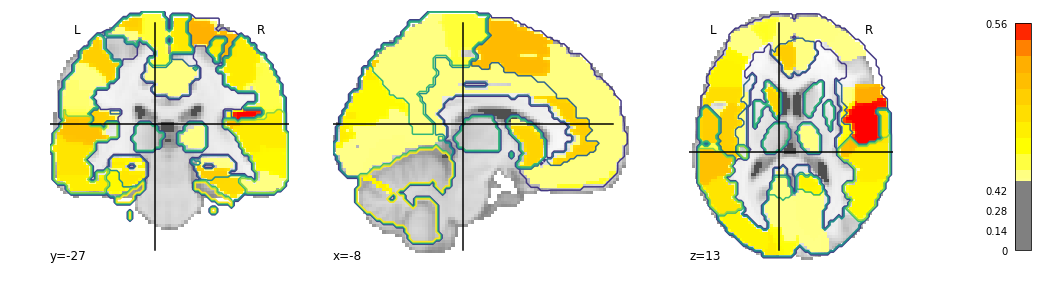

In [20]:
cmap = make_colormap([c('white'), 0.4 , c('white'), c('yellow'), 0.6,  c('yellow'), c('orange'), 0.9, c('orange') , c('red')])

norm = MidPointNorm(midpoint=0.55)
# norm_l = norm_g = norm_w = norm_c = norm
vmax = 0.74
# lstm_max = glove_max = word_max = charword_max


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(lstm_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
#                                   display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = lstm_max,
                                    norm = norm_l,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('LSTM-HD', y=1.2)
fig.savefig('plot/lstm_brain_statmap.png', bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(glove_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
#                                   display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = glove_max,
                                    norm = norm_g,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('GloVe', y=1.2)
fig.savefig('plot/glove_brain_statmap.png', bbox_inches='tight', dpi=300)


fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(word_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
#                                   display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = word_max,
                                    norm = norm_w,
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('OutWord-Emb', y=1.2)
fig.savefig('plot/word_brain_statmap.png', bbox_inches='tight', dpi=300)

fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(charword_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
#                                   display_mode='lyrz',
                                    cmap = cmap,
                                    vmax = charword_max,
                                    norm = norm_c,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 
# display.title('CharWord-Emb', y=1.2)
fig.savefig('plot/charword_brain_statmap.png', bbox_inches='tight', dpi=300)


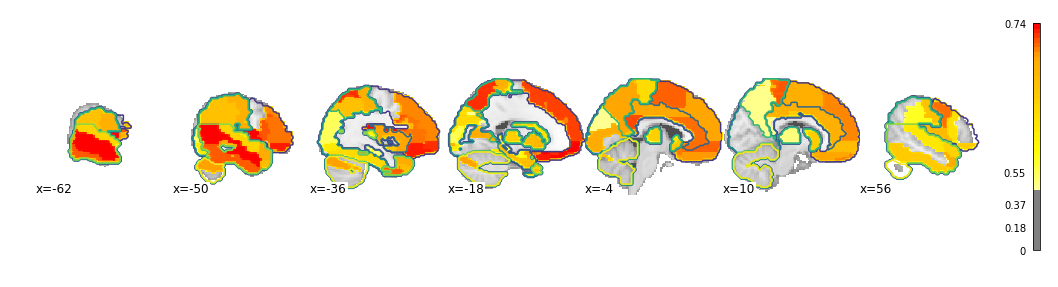

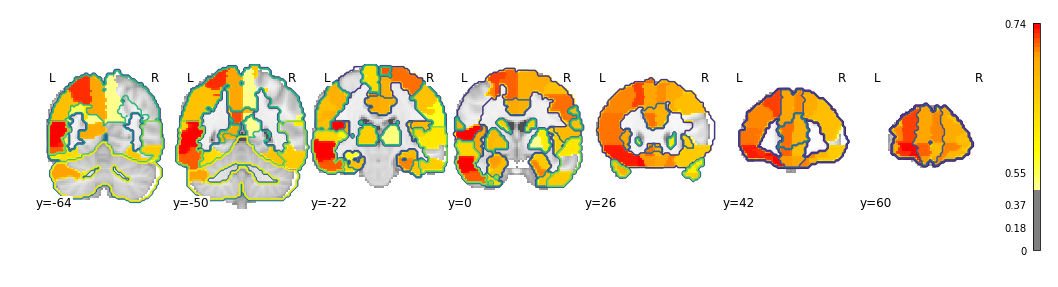

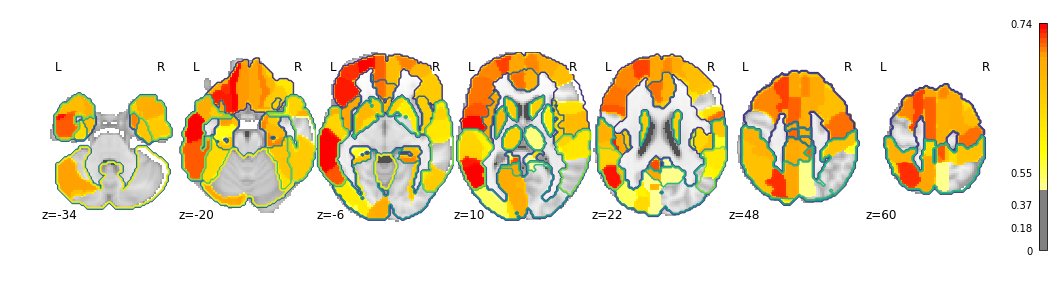

In [21]:
cmap = make_colormap([c('white'), 0.4 , c('white'), c('yellow'), 0.6,  c('yellow'), c('orange'), 0.9, c('orange') , c('red')])

fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(lstm_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
                                  display_mode='x',
                                    cmap = cmap,
                                    vmax = lstm_max,
                                    norm = norm_l,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 

cmap = make_colormap([c('white'), 0.4 , c('white'), c('yellow'), 0.6,  c('yellow'), c('orange'), 0.9, c('orange') , c('red')])
fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(lstm_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
                                  display_mode='y',
                                    cmap = cmap,
                                    vmax = lstm_max,
                                    norm = norm_l,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 

cmap = make_colormap([c('white'), 0.4 , c('white'), c('yellow'), 0.6,  c('yellow'), c('orange'), 0.9, c('orange') , c('red')])
fig = plt.figure(figsize=(14, 3.5)) 
display = plotting.plot_stat_map(lstm_img, 
                                  threshold=0.5,
                                  colorbar=True, 
#                                   plot_abs=False,
                                  display_mode='z',
                                    cmap = cmap,
                                    vmax = lstm_max,
                                    norm = norm_l,                                    
                                    figure = fig
                                  )

display.add_contours(AAL_img, 
#                      color='black'
) 


